# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Данные

In [ ]:
# !unzip data.zip

In [ ]:
# !pip install --upgrade scikit-learn

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector, ColumnTransformer

PATH_TO_DATA = 'data'
# PATH_TO_DATA = '../input/churn-prediction-spec'

In [2]:
df = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_data.train'))
y = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_labels.train'), header=None, squeeze=True)

In [3]:
nan_cols = df.columns[df.isna().all()]
df.drop(nan_cols, axis=1, inplace=True)

In [4]:
# cat_cols = df.select_dtypes(include='object').columns
# df[cat_cols] = df[cat_cols].astype('category')

In [5]:
df_train, df_ho, y_train, y_valid = train_test_split(df, y, test_size=5000)

In [100]:
class DataFramer(BaseEstimator, TransformerMixin):
    def __init__(self, columns, index):
        super().__init__()
        self.columns = columns
        self.index = index

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return pd.DataFrame(X, columns=self.columns)

In [98]:
numeric_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
#     ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="object")),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

preprocessor_pipeline = Pipeline([
#     ('nan_columns_dropper', NanColumnsDropper()),
    ('preprocessor', preprocessor),
#     ('scaler', StandardScaler()),
    ('to_dataframe', DataFramer(df.columns, df_train.index))
])

In [99]:
%%time
X_train = preprocessor_pipeline.fit_transform(df_train)
X_valid = preprocessor_pipeline.fit_transform(df_ho)
X_train

ValueError: Shape of passed values is (5000, 212), indices imply (35000, 212)

## Модель

In [9]:
# !pip install catboost

In [11]:
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier

In [12]:
cv = StratifiedShuffleSplit(n_splits=8, random_state=2179)

In [13]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list()
)

# model = LogisticRegression(solver='liblinear')

In [14]:
%%time
model.fit(X_train, y_train)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

Learning rate set to 0.388375
0:	learn: 0.3926711	total: 92.7ms	remaining: 9.18s
1:	learn: 0.3051129	total: 128ms	remaining: 6.27s
2:	learn: 0.2669722	total: 163ms	remaining: 5.26s
3:	learn: 0.2578387	total: 199ms	remaining: 4.78s
4:	learn: 0.2543349	total: 217ms	remaining: 4.12s
5:	learn: 0.2485871	total: 241ms	remaining: 3.78s
6:	learn: 0.2446862	total: 266ms	remaining: 3.53s
7:	learn: 0.2429481	total: 281ms	remaining: 3.23s
8:	learn: 0.2418145	total: 303ms	remaining: 3.06s
9:	learn: 0.2404157	total: 328ms	remaining: 2.95s
10:	learn: 0.2388591	total: 350ms	remaining: 2.83s
11:	learn: 0.2380175	total: 377ms	remaining: 2.77s
12:	learn: 0.2371690	total: 403ms	remaining: 2.7s
13:	learn: 0.2348770	total: 427ms	remaining: 2.62s
14:	learn: 0.2344648	total: 444ms	remaining: 2.52s
15:	learn: 0.2341658	total: 470ms	remaining: 2.46s
16:	learn: 0.2335697	total: 492ms	remaining: 2.4s
17:	learn: 0.2332697	total: 514ms	remaining: 2.34s
18:	learn: 0.2329656	total: 537ms	remaining: 2.29s
19:	learn: 0

In [15]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [16]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train, 
                         y=y_train, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc',
                         error_score='raise')
print(scores, '\n', scores.mean())

[0.7047796  0.73525265 0.7084184  0.71766688 0.73186846 0.72689885
 0.71072286 0.72736917] 
 0.7203721079358194
CPU times: user 1.09 s, sys: 310 ms, total: 1.4 s
Wall time: 32.4 s


In [ ]:
# %%time
# gb_classifier = GradientBoostingClassifier(random_state=2179)
# gb_classifier.fit(X_train, y_train)
# print(roc_auc_score(y_valid, gb_classifier.predict_proba(X_valid)[:, 1]))

|Модель|ho ROC AUC|cv ROC AUC|
|-|-|-|
|CatBoost|0.726979139706712|0.7203721079358194|

# Инструкции

## 1. Learning curve

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [17]:
from sklearn.model_selection import  learning_curve

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (13, 8)
import seaborn as sns
sns.set()

In [19]:
%%time
train_sizes_abs, train_scores, test_scores, fit_times, score_times = learning_curve(
    estimator=model, # catboost
    X=X_train,
    y=y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    return_times=True
)

CPU times: user 13.5 s, sys: 3.4 s, total: 16.9 s
Wall time: 2min 8s


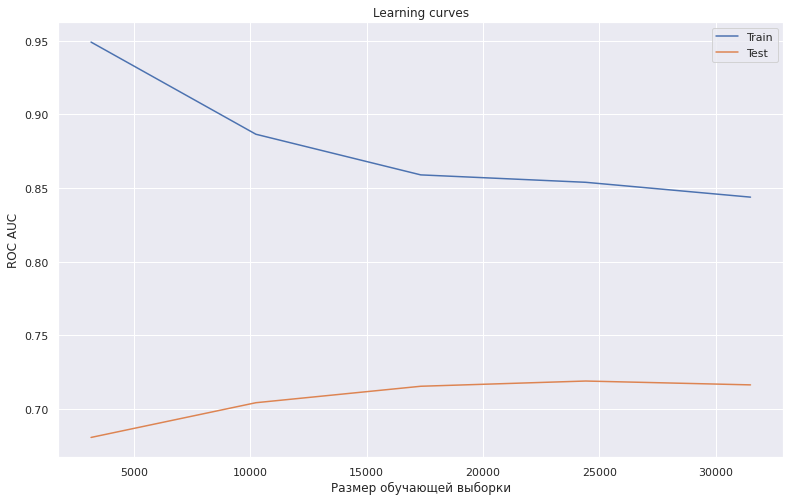

In [20]:
plt.plot(train_sizes_abs, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes_abs, test_scores.mean(axis=1), label='Test')
plt.legend()
plt.xlabel('Размер обучающей выборки')
plt.ylabel('ROC AUC')
plt.title('Learning curves');

## 2. Balancing

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

### 2.1 Веса

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [21]:
y_train.value_counts()[1] / y_train.value_counts()[-1], y_train.value_counts()[-1] / y_train.value_counts()[1]

(0.08088076341064204, 12.363879343260786)

In [34]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
#     auto_class_weights='Balanced',
    scale_pos_weight=12
)

pipeline = Pipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', model)
])

In [35]:
%%time
model.fit(X_train, y_train)
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.6914508211210395
CPU times: user 25.8 s, sys: 2.74 s, total: 28.5 s
Wall time: 3.42 s


In [36]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train, 
                         y=y_train, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc')
print(scores, '\n', scores.mean())

[0.66853066 0.72201175 0.68848102 0.69143025 0.69869017 0.71845664
 0.68961497 0.70580393] 
 0.6978774241002599
CPU times: user 1.04 s, sys: 53.7 ms, total: 1.09 s
Wall time: 32 s


|parameter|hold out ROC AUC|cv ROC AUC|
|-|-|-|
|no|0.726979139706712|0.7203721079358194|
|auto_class_weights='Balanced'|0.6942507349698442|0.6917056341913065|
|auto_class_weights='SqrtBalanced'|0.6963278957932516|0.7072319875146754|
|scale_pos_weight=12|0.6914508211210395|0.6978774241002599|
|scale_pos_weight=0.08|0.7249339537667319|0.7268670228064633|

### 2.2 Undersampling

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [37]:
import random

In [38]:
df_train_n_churn = df_train[y_train == -1]

In [44]:
THRESH = 73

df_train_undersampling = pd.concat([df_train_n_churn.dropna(thresh=THRESH), df_train[y_train == 1]])

X_train_undersampling = preprocessor_pipeline.fit_transform(df_train_undersampling)
X_train_undersampling = pd.DataFrame(X_train_undersampling, columns=df.columns)

In [ ]:
SIZE = 20000

sample = random.sample(df_train_n_churn.index.to_list(), SIZE)

df_train_undersampling = pd.concat([df_train_n_churn.loc[sample], df_train[y_train == 1]])

X_train_undersampling = preprocessor_pipeline.fit_transform(df_train_undersampling)
X_train_undersampling = pd.DataFrame(X_train_undersampling, columns=preprocessor_pipeline['nan_columns_dropper'].cols)

In [41]:
model = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
)

In [45]:
%%time
model.fit(X_train_undersampling, y_train[df_train_undersampling.index])
print(roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]))

0.6366054498473953
CPU times: user 12.1 s, sys: 2.87 s, total: 15 s
Wall time: 1.99 s


In [83]:
class Undersampler(BaseEstimator, TransformerMixin):
    def __init__(self, threshold, y):
        super().__init__()
        self.threshold = threshold
        self.y = y

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_n_churn = X.loc[self.y == -1]
        return X #pd.concat([X_n_churn.dropna(thresh=self.threshold), X[self.y == 1]])

In [82]:
df_train[y_train == -1]

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
17955,NaN,NaN,NaN,NaN,NaN,385.0,7.0,NaN,NaN,NaN,...,AI5YWu3,oslk,H2lRusu,LM8l689qOp,NaN,ELof,xb3V,RAYp,F2FyR07IdsN7I,mj86
26586,NaN,NaN,NaN,NaN,NaN,5348.0,0.0,NaN,NaN,NaN,...,L91KIiz,oslk,CE7uk3u,jySVZNlOJy,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN
1016,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,...,7OmVzos,oslk,76DJixu,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN
7886,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,...,gOr5cpt,zCkv,UpJuOS_,LM8l689qOp,4n2X,NaN,kwS7,6fzt,F2FcTt7IdMT_v,NaN
2635,NaN,NaN,NaN,NaN,NaN,3787.0,7.0,NaN,NaN,NaN,...,Xei0nTz,oslk,4sF7qqc,NaN,NaN,kG3k,FSa2,RAYp,55YFVY9,mj86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13201,NaN,NaN,NaN,NaN,NaN,1659.0,7.0,NaN,NaN,NaN,...,ylC3DH0,oslk,kiBhOcm,LM8l689qOp,NaN,ELof,Aoh3,RAYp,55YFVY9,am7c
2462,NaN,NaN,NaN,NaN,NaN,616.0,7.0,NaN,NaN,NaN,...,AOhuZGO,oslk,W8mwS9i,LM8l689qOp,NaN,NaN,Qu4f,RAYp,F2FyR07IdsN7I,NaN
25399,NaN,NaN,NaN,NaN,NaN,847.0,7.0,NaN,NaN,NaN,...,UF16siJ,zCkv,APgdzOv,LM8l689qOp,NaN,NaN,WqMG,6fzt,Zy3gnGM,NaN
16296,NaN,NaN,NaN,NaN,NaN,6650.0,7.0,NaN,NaN,NaN,...,7Om87dl,oslk,ZXdOTZB,LM8l689qOp,NaN,kG3k,fKCe,RAYp,F2FyR07IdsN7I,mj86


In [86]:
X_train

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var9,Var10,Var11,...,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229
0,-0.0363,-0.005345,-0.015388,-0.018862,-0.059144,-0.259987,0.032372,-0.03652,-0.062562,-0.034592,...,h72fSEp,oslk,e7bTQlu,LM8l689qOp,4n2X,ELof,TNEC,RAYp,F2FyR07IdsN7I,am7c
1,-0.0363,-0.005345,-0.015388,-0.018862,-0.059144,-0.319155,0.032372,-0.03652,-0.062562,-0.034592,...,AI5YWu3,oslk,H2lRusu,LM8l689qOp,4n2X,ELof,xb3V,RAYp,F2FyR07IdsN7I,mj86
2,-0.0363,-0.005345,-0.015388,-0.018862,-0.059144,1.678463,-1.154053,-0.03652,-0.062562,-0.034592,...,L91KIiz,oslk,CE7uk3u,jySVZNlOJy,4n2X,ELof,FSa2,RAYp,F2FyR07IdsN7I,am7c
3,-0.0363,-0.005345,-0.015388,-0.018862,-0.059144,-0.474118,-1.154053,-0.03652,-0.062562,-0.034592,...,7OmVzos,oslk,76DJixu,LM8l689qOp,4n2X,ELof,7P5s,RAYp,F2FyR07IdsN7I,am7c
4,-0.0363,-0.005345,-0.015388,-0.018862,-0.059144,-0.474118,0.032372,-0.03652,-0.062562,-0.034592,...,gOr5cpt,zCkv,UpJuOS_,LM8l689qOp,4n2X,ELof,kwS7,6fzt,F2FcTt7IdMT_v,am7c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,-0.0363,-0.005345,-0.015388,-0.018862,-0.059144,0.193632,0.032372,-0.03652,-0.062562,-0.034592,...,ylC3DH0,oslk,kiBhOcm,LM8l689qOp,4n2X,ELof,Aoh3,RAYp,55YFVY9,am7c
34996,-0.0363,-0.005345,-0.015388,-0.018862,-0.059144,-0.226177,0.032372,-0.03652,-0.062562,-0.034592,...,AOhuZGO,oslk,W8mwS9i,LM8l689qOp,4n2X,ELof,Qu4f,RAYp,F2FyR07IdsN7I,am7c
34997,-0.0363,-0.005345,-0.015388,-0.018862,-0.059144,-0.133199,0.032372,-0.03652,-0.062562,-0.034592,...,UF16siJ,zCkv,APgdzOv,LM8l689qOp,4n2X,ELof,WqMG,6fzt,Zy3gnGM,am7c
34998,-0.0363,-0.005345,-0.015388,-0.018862,-0.059144,2.20252,0.032372,-0.03652,-0.062562,-0.034592,...,7Om87dl,oslk,ZXdOTZB,LM8l689qOp,4n2X,kG3k,fKCe,RAYp,F2FyR07IdsN7I,mj86


In [84]:
THRESH = 70

pipeline = Pipeline([
    ('preprocessor', preprocessor_pipeline),
    ('undersampler', Undersampler(THRESH, y_train)),
    ('model', model)
])

In [85]:
%%time
scores = cross_val_score(estimator=pipeline, 
                         X=df_train, 
                         y=y_train, 
                         cv=cv, 
                         n_jobs=-1, 
                         scoring='roc_auc',
                         error_score='raise')
print(scores, '\n', scores.mean())

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

|threshold|ho ROC AUC|cv ROC AUC|
|-|-|-|
|70|0.6533814042524182|0.8553871835162432|
|73|0.6537689557046605||
|75|0.6138739774269679||

|size|ho ROC AUC|cv ROC AUC|
|-|-|-|
|32395|0.7306666806416131|0.7339981555761623|
|30000|0.7388705564765433|0.7220597062579821|
|25000|0.7286915548816526||
|20000|0.7157682231845526|0.7323397988505748|

## 3. Признаки

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [ ]:
from catboost import CatBoostClassifier

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import roc_auc_score

In [ ]:
cv = StratifiedShuffleSplit(n_splits=8, random_state=2179)

Стратегия 1: замена на самое частое значение

In [ ]:
numeric_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    # ('ordinal_encoder', OrdinalEncoder())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="object")),
    ('cat', categorical_transformer, selector(dtype_include="object"))
])

preprocessor_pipeline = Pipeline([
#     ('nan_columns_dropper', NanColumnsDropper()),
    ('preprocessor', preprocessor),
    # ('scaler', StandardScaler())
    ('to_dataframe', DataFramer(df.columns))
])

In [ ]:
%%time
X_train = preprocessor_pipeline.fit_transform(df_train)
X_valid = preprocessor_pipeline.fit_transform(df_ho)
X_train

In [ ]:
catboost_classifier = CatBoostClassifier(
    max_depth=6, 
    n_estimators=100, 
    cat_features=df_train.select_dtypes(include='object').columns.to_list(),
    logging_level='Silent',
)

pipeline = Pipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', catboost_classifier)
])

In [ ]:
%%time
pipeline.fit(df_train, y_train)
print(roc_auc_score(y_valid, pipeline.predict_proba(df_ho)[:, 1]))

In [ ]:
%%time
catboost_classifier.fit(X_train, y_train)
print(roc_auc_score(y_valid, catboost_classifier.predict_proba(X_valid)[:, 1]))

In [ ]:
%%time
scores = cross_val_score(estimator=pipeline, X=df_train, y=y_train, cv=2, n_jobs=-1, 
                         scoring='roc_auc', error_score='raise')
print(scores, '\n', scores.mean())

|method num|method cat|ho ROC AUC|cv ROC AUC|
|-|-|-|-|
|most_frequent|most_frequent|0.6968358651677504||
|mean|most_frequent|0.740488069223951||
|median|most_frequent|0.7322809985168804||

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

# Тест

In [ ]:
def write_to_submission_file(predicted_labels, out_file,
                             target='result', index_label="id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(0, predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_test_data.csv'), index_col=0)
df_test

In [ ]:
%%time
X_test = preprocessor_pipeline.fit_transform(df_test)
X_test = pd.DataFrame(X_test, columns=preprocessor_pipeline['nan_columns_dropper'].cols)#.astype('int')
X_test

In [ ]:
%%time
# catboost_classifier.fit(X_train_all, y)
prediction = catboost_classifier.predict_proba(X_test)

In [ ]:
write_to_submission_file(prediction[:, 1], 'result.csv')